In [33]:
import os
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.io import imsave
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

In [19]:
BASE_DIR = Path(r"F:\spatial_data\processed")
RUN_ID = '20240805_TCR_PRISM30_TNBC_BZ02_CA2_immune_no16,17,18'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
read_dir.mkdir(exist_ok=True)
check_dir = read_dir / 'check'
check_dir.mkdir(exist_ok=True)

1. extract Actb spots from two approach
2. find subtraction spots, get some coordinates
3. find those coordinates example in raw image(stitched)

In [21]:
intensity = pd.read_csv(read_dir/'intensity_deduplicated.csv', index_col=0)
print(len(intensity))
intensity.head()

2140165


,Y,X,Channel,R,Ye,G,B,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,G/A
0,17140,2383,cy5,16635,4555,1891,26251.25,16635,4555,4727.5,19688.4375,40879.4375,0.115645
1,3116,13071,cy5,15907,5736,2127,14768.25,15907,5736,5317.5,11076.1875,32720.1875,0.162514
2,5470,10148,cy5,13484,0,0,0.00,13484,0,0.0,0.0000,13485.0000,0.000000
3,9667,9646,cy5,11344,2481,2593,4390.75,11344,2481,6482.5,3293.0625,17119.0625,0.378671
4,9677,9656,cy5,10237,5072,1487,18483.25,10237,5072,3717.5,13862.4375,29172.4375,0.127432


In [22]:
mapped_genes = pd.read_csv(read_dir / 'mapped_genes.csv', index_col=0)
print(len(mapped_genes))
mapped_genes.head()

1204087


,Y,X,Gene
25,8061,8664,CD3D
26,3961,10474,CD3D
28,10768,11821,CD3D
30,9771,10953,CD3D
32,1252,11624,CD3D


# Intensity analysis

In [23]:
# crosstalk elimination
intensity['B'] = intensity['B'] - intensity['G'] * 0.25
intensity['B'] = np.maximum(intensity['B'], 0)

# Scale
intensity['Scaled_R'] = intensity['R']
intensity['Scaled_Ye'] = intensity['Ye']
intensity['Scaled_G'] = intensity['G'] * 2.5
intensity['Scaled_B'] = intensity['B']

# threshold by intensity
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity['sum_G'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B'] + intensity['Scaled_G']

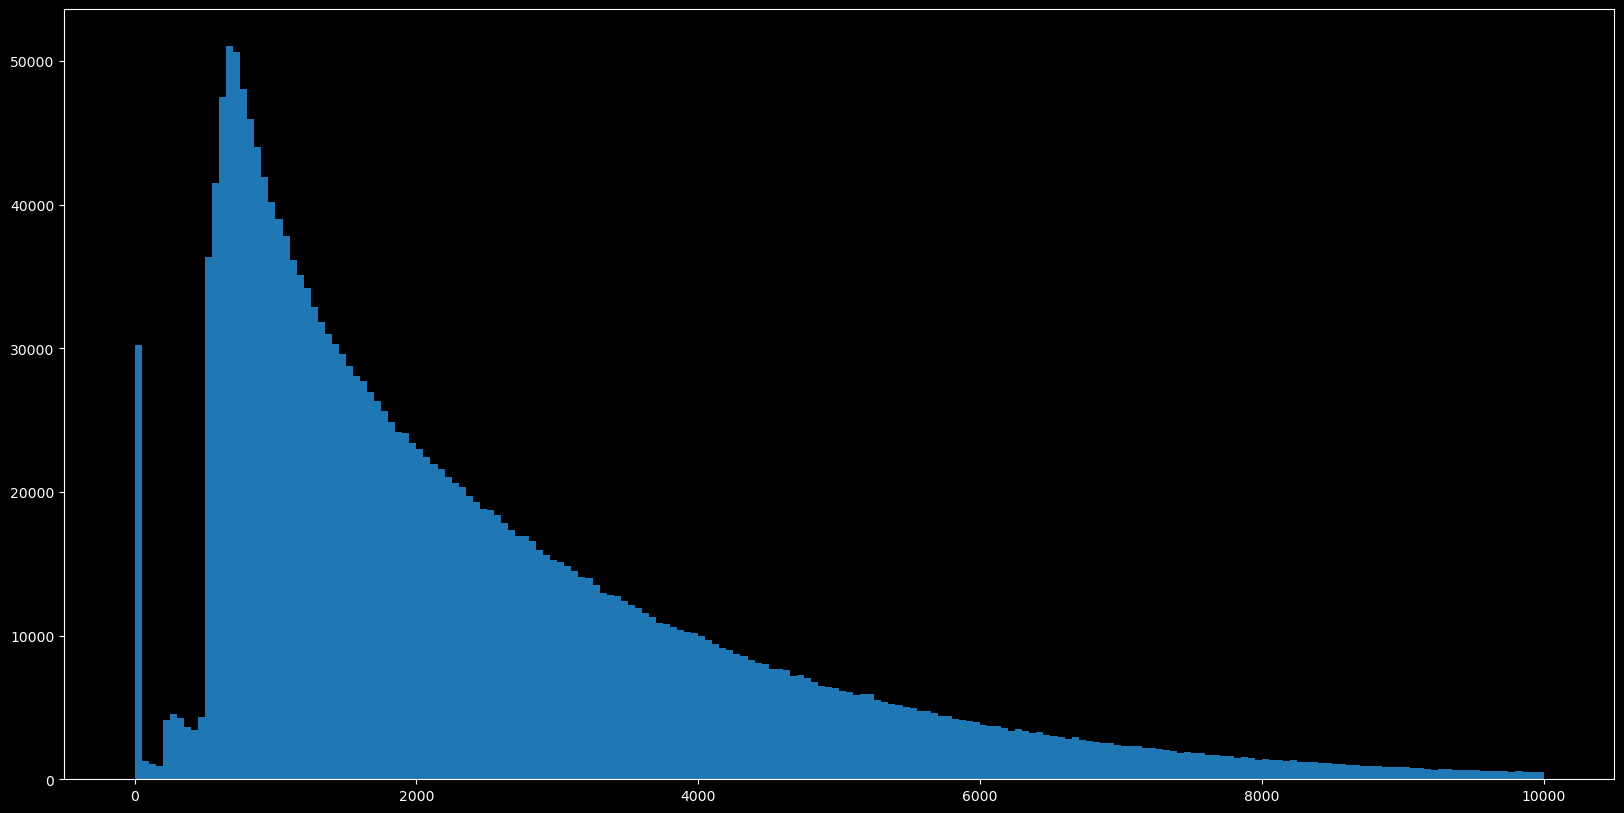

In [24]:
plt.figure(figsize=(20,10))
plt.hist(intensity['sum'], bins=200, range=[0, 10000])
plt.show()

# Snr analysis

In [25]:
# intensity.loc[intensity['snr']>20, 'snr'] = 20
# plt.figure(figsize=(20,10))
# plt.hist(intensity.loc[:, 'snr'], bins=1000)
# plt.show()

In [26]:
# plt.figure(figsize=(20,10))
# plt.hist(intensity['sum_G'], bins=200, range=[100,5000])
# plt.show()

In [27]:
# data = intensity[intensity['sum']>750]
# data = data[data['label']>15]

# label_counts = data['label'].value_counts()
# label_percentages = label_counts / label_counts.sum()

# plt.figure(figsize=(8, 8))  # 设置图形的大小
# plt.pie(label_percentages, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
# plt.axis('equal')
# plt.legend()
# plt.show()

# Save spots raw images

In [28]:
gene_list = pd.read_csv(src_dir / 'gene_list.csv')['gene'].tolist()

In [29]:
channels = {'cy5','cy3','FAM','TxRed'}
spots = {}

for gene in gene_list: spots[gene] = mapped_genes[mapped_genes['Gene'] == gene].sample(n=20)

# os.makedirs(check_dir / 'morethan750', exist_ok=True)
for chn in channels:
    im = imread(stc_dir / f'cyc_1_{chn}.tif')
    for gene_index, gene in enumerate(spots.keys(), start=1):
        for index, spot in spots[gene].iterrows():
            x_start = int(spot['X'])
            y_start = int(spot['Y'])
    
            im_cut = im[max(0, y_start-15): min(im.shape[0], y_start+16), 
                        max(0, x_start-15): min(im.shape[1], x_start+16)]
            imsave(check_dir / f'{gene_index}_{gene}_{index}_{chn}_crop.tif', im_cut, check_contrast=False)

In [30]:
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['text.color'] = 'white'

# Function to extract the central 10x10 region and the diagonal from it
def extract_center_and_diagonal(channel, center_size=11, position='sequence'):
    start_idx = (channel.shape[0] - center_size) // 2
    end_idx = start_idx + center_size
    center_region = channel[start_idx:end_idx, start_idx:end_idx]
    if position == 'sequence': return np.diagonal(center_region)
    elif position == 'nonsequence': return np.diagonal(np.fliplr(center_region))

def one_point(red, yellow, blue, green, axes, index, center_size=11):
    ax_im = axes[0]
    ax_imsub = axes[1]
    ax_plot = axes[2]
    ax_plot2 = axes[3]
    # Convert uint16 data to float32 to avoid overflow and for processing
    red = (red - np.mean(red)).astype(np.float32)
    yellow = (yellow - np.mean(yellow)).astype(np.float32)
    blue = (blue - np.mean(blue)).astype(np.float32)
    green = ((green - np.mean(green))*2.5).astype(np.float32)

    # Decompose the yellow channel into red and green
    red_effective = np.clip(red + 0.5 * yellow, 0, 65535)
    green_effective = np.clip(green + 0.5 * yellow, 0, 65535)
    blue_effective = np.clip(blue, 0, 65535)  # Blue channel remains unchanged
    rgb_image = np.stack((red_effective/3000, green_effective/3000, blue_effective/3000), axis=-1)
    rgb_image = np.clip(rgb_image, 0, 1)

    # Calculate the starting index
    start_index = (rgb_image.shape[0] - center_size) // 2
    end_index = start_index + center_size
    center_region = rgb_image[start_index:end_index, start_index:end_index]


    # Setup the figure and subplots
    ax_im.imshow(rgb_image)
    ax_im.set_title(index)
    ax_imsub.imshow(center_region)
    ax_imsub.set_title('Center 10x10 Region')

    # Extract diagonals
    diag_red = extract_center_and_diagonal(red, center_size=center_size)
    diag_yellow = extract_center_and_diagonal(yellow, center_size=center_size)
    diag_blue = extract_center_and_diagonal(blue, center_size=center_size)
    diag_green = extract_center_and_diagonal(green, center_size=center_size)
    ax_plot.plot(diag_red, 'r-', label='Red')
    ax_plot.plot(diag_green, 'g-', label='Green')
    ax_plot.plot(diag_blue, 'b-', label='Blue')
    ax_plot.plot(diag_yellow, 'y-', label='Yellow')
    ax_plot.set_title('Diagonal Intensity Distribution')
    ax_plot.set_xlabel('Diagonal Index')
    ax_plot.set_ylabel('Intensity')
    ax_plot.legend()

    # Extract diagonals in another position
    diag_red = extract_center_and_diagonal(red, center_size=center_size, position='nonsequence')
    diag_yellow = extract_center_and_diagonal(yellow, center_size=center_size, position='nonsequence')
    diag_blue = extract_center_and_diagonal(blue, center_size=center_size, position='nonsequence')
    diag_green = extract_center_and_diagonal(green, center_size=center_size, position='nonsequence')
    ax_plot2.plot(diag_red, 'r-', label='Red')
    ax_plot2.plot(diag_green, 'g-', label='Green')
    ax_plot2.plot(diag_blue, 'b-', label='Blue')
    ax_plot2.plot(diag_yellow, 'y-', label='Yellow')
    ax_plot2.set_title('Diagonal Intensity Distribution')
    ax_plot2.set_xlabel('Diagonal Index')
    ax_plot2.set_ylabel('Intensity')
    ax_plot2.legend()

In [31]:
for gene_index, gene in tqdm(enumerate(gene_list, start=1), total=len(gene_list), desc='Drawing_spots'):
    index_list = [_.split('_')[-3] for _ in os.listdir(check_dir) if _.split('_')[0]==f'{gene_index}']
    points = {}
    for index in index_list:
        red = imread(check_dir / f'{gene_index}_{gene}_{index}_cy5_crop.tif')
        yellow = imread(check_dir / f'{gene_index}_{gene}_{index}_TxRed_crop.tif')
        blue = imread(check_dir / f'{gene_index}_{gene}_{index}_FAM_crop.tif')
        green = imread(check_dir / f'{gene_index}_{gene}_{index}_cy3_crop.tif')
        points[index] = {'red':red, 'green':green, 'blue':blue, 'yellow':yellow}
    # points
    fig, axes = plt.subplots(ncols=4, nrows=len(points), figsize=(16, 4*len(points)))
    for i, (index, point) in enumerate(points.items()):
        red = point['red']
        green = point['green']
        blue = point['blue']
        yellow = point['yellow']
        one_point(red,yellow,blue,green,axes=axes[i,:],index=index)
    plt.tight_layout()

    plt.savefig(check_dir / f'_overall_{gene_index}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)

Drawing_spots: 100%|██████████| 30/30 [08:27<00:00, 16.92s/it]


In [32]:
# index = 694667
# y, x = intensity.loc[index, ['Y', 'X']]
# print(mapped_genes.loc[index])
# intensity[(intensity['Y'] >= y - 5) & (intensity['Y'] <= y + 5) &
#           (intensity['X'] >= x - 5) & (intensity['X'] <= x + 5)]